In [1]:
# Paso 0: Importar librerias necesarias

import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import pylab as plt
from pandas.plotting import lag_plot


In [2]:
# Paso 1: Importar el DF de todas las empresas del IBEX 35

df = pd.read_csv('ibex35.csv')

df.head()

,id,ticker,empresa,date,open,high,low,close,adj close,volume
0,1,ANA,Acciona,2019-01-02,73.900002,73.900002,73.900002,73.900002,64.148270,0
1,1,ANA,Acciona,2022-06-24,174.199997,178.800003,174.000000,178.800003,169.562302,0
2,1,ANA,Acciona,2022-06-23,169.899994,173.199997,169.000000,173.000000,164.061951,0
3,1,ANA,Acciona,2022-06-22,171.399994,171.399994,168.800003,170.199997,161.406616,0
4,1,ANA,Acciona,2022-06-21,179.699997,179.699997,172.300003,173.600006,164.630966,0


In [3]:
# Paso 2: Filtrar por la empresa sobre la que realizar el modelo

bbva = df[df['empresa'] == 'BBVA']

bbva.shape

(1325, 10)

In [4]:
# Paso 3: Seleccionar las columnas definitivas que utilizaremos

bbva = bbva [['date','open','high','low','close','adj close']]

bbva.shape

(1325, 6)

In [5]:
# Paso 4: Modificar el formato de columna 'date' (format: object ===> datatime)

bbva['date'] = pd.to_datetime(bbva['date'], format="%Y-%m-%d")

bbva.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1325 entries, 12600 to 13924
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1325 non-null   datetime64[ns]
 1   open       1325 non-null   float64       
 2   high       1325 non-null   float64       
 3   low        1325 non-null   float64       
 4   close      1325 non-null   float64       
 5   adj close  1325 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 72.5 KB


In [6]:
# Paso 5: Ordenar el DF por fecha

bbva.sort_values(by='date',ascending= True, inplace=True)

bbva.head()

,date,open,high,low,close,adj close
13483,2019-01-02,4.5735,4.6960,4.5100,4.6635,3.549864
13482,2019-01-03,4.6260,4.7390,4.6260,4.6760,3.559379
13481,2019-01-04,4.7385,4.8780,4.7220,4.8505,3.692209
13480,2019-01-07,4.8835,4.8935,4.8010,4.8335,3.679268
13479,2019-01-08,4.8600,4.9235,4.8345,4.8745,3.710477


In [7]:
# Paso 6: Filtrar nuevamente para eliminar efecto COVID del análisis (previo a 2021)

# Filtro:

fecha_inicio = '2021-01-01'
fecha_fin = '2024-03-01'

bbva = bbva[(bbva['date'] >= fecha_inicio) & (bbva['date'] <= fecha_fin)]

# Comprobar si se ha aplicado correctamente

bbva.shape

(812, 6)

In [8]:
# Paso 7: Añadir al DF fechas obviadas por mercado de valores español (fin de semana y festivos)

# Rango de fechas desde '2021-01-01' a '2024-03-01'

date_range = pd.date_range(start=bbva['date'].min(), end=bbva['date'].max(), freq='D')

# Reindexa el DF con el nuevo rango de fechas

bbva = bbva.set_index('date').reindex(date_range).reset_index()

# Volver a modificar el nombre de columna 'date'

bbva = bbva.rename(columns={'index': 'date'})


In [9]:
# Paso 8: Comprobar que ha introducido la fechas ausentes en el DF original

bbva.head(10)

,date,open,high,low,close,adj close
0,2021-01-04,4.098,4.098,3.983,4.078,3.453894
1,2021-01-05,4.040,4.093,4.022,4.074,3.450506
2,2021-01-06,4.155,4.360,4.155,4.309,3.649541
3,2021-01-07,4.331,4.364,4.236,4.352,3.685961
4,2021-01-08,4.375,4.375,4.243,4.276,3.621592
5,2021-01-09,NaN,NaN,NaN,NaN,NaN
6,2021-01-10,NaN,NaN,NaN,NaN,NaN
7,2021-01-11,4.275,4.309,4.213,4.251,3.600418
8,2021-01-12,4.284,4.295,4.243,4.256,3.604652
9,2021-01-13,4.250,4.264,4.191,4.196,3.553835


In [10]:
# Paso 9: Rellenar valores nulos con el anterior valor de la columna(viernes o previo a festivo)

bbva = bbva.fillna(method='ffill')

In [11]:
# Paso 10: Comprobar que se han introducido los valores correctamente


bbva.head(10)

,date,open,high,low,close,adj close
0,2021-01-04,4.098,4.098,3.983,4.078,3.453894
1,2021-01-05,4.040,4.093,4.022,4.074,3.450506
2,2021-01-06,4.155,4.360,4.155,4.309,3.649541
3,2021-01-07,4.331,4.364,4.236,4.352,3.685961
4,2021-01-08,4.375,4.375,4.243,4.276,3.621592
5,2021-01-09,4.375,4.375,4.243,4.276,3.621592
6,2021-01-10,4.375,4.375,4.243,4.276,3.621592
7,2021-01-11,4.275,4.309,4.213,4.251,3.600418
8,2021-01-12,4.284,4.295,4.243,4.256,3.604652
9,2021-01-13,4.250,4.264,4.191,4.196,3.553835


In [12]:
# Paso 11: Establecer columna 'date' como índice para modelo

bbva = bbva.set_index('date')

bbva.head(10)

,open,high,low,close,adj close
date,,,,,
2021-01-04,4.098,4.098,3.983,4.078,3.453894
2021-01-05,4.040,4.093,4.022,4.074,3.450506
2021-01-06,4.155,4.360,4.155,4.309,3.649541
2021-01-07,4.331,4.364,4.236,4.352,3.685961
2021-01-08,4.375,4.375,4.243,4.276,3.621592
2021-01-09,4.375,4.375,4.243,4.276,3.621592
2021-01-10,4.375,4.375,4.243,4.276,3.621592
2021-01-11,4.275,4.309,4.213,4.251,3.600418
2021-01-12,4.284,4.295,4.243,4.256,3.604652


In [13]:
# Paso 12: Establecer siguiente criterio para que el modelo AR funcione

bbva.index = pd.DatetimeIndex(bbva.index).to_period('d')

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

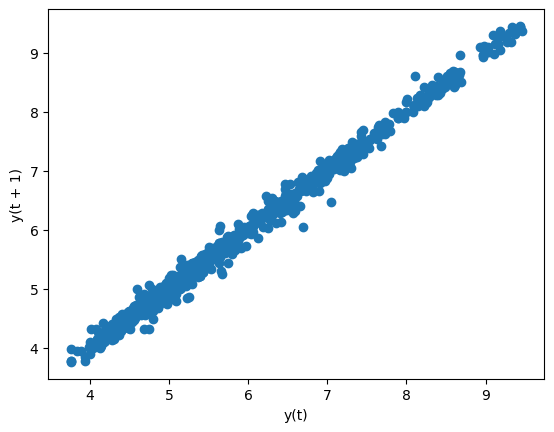

In [14]:
# Paso 13: Comprobar linealidad de la variable y = 'close'

lag_plot(bbva.close)

In [15]:
# Paso 14: Importar modelo de AR

from statsmodels.tsa.ar_model import AutoReg as AR

In [16]:
# Paso 15: Realizar el split en el DF del train y el test

train, test = bbva.close[:-10], bbva.close[-10:]

train.shape, test.shape

((1143,), (10,))

In [17]:
# Paso 16: Entrenar el modelo de AR

modelo = AR(train, lags=1).fit()

In [18]:
# Paso 17: Realizar predicción con el entrenamiento

pred = modelo.predict(len(train), len(bbva.close)-1)

# Check sobre los valores de la predicción

pred

2024-02-21    9.099752
2024-02-22    9.101503
2024-02-23    9.103253
2024-02-24    9.105001
2024-02-25    9.106748
2024-02-26    9.108493
2024-02-27    9.110237
2024-02-28    9.111980
2024-02-29    9.113721
2024-03-01    9.115460
Freq: D, dtype: float64

In [19]:
# Paso 18: Chequear coincidencia entre test y pred

test

date
2024-02-21    9.294
2024-02-22    9.332
2024-02-23    9.430
2024-02-24    9.430
2024-02-25    9.430
2024-02-26    9.456
2024-02-27    9.370
2024-02-28    9.320
2024-02-29    9.186
2024-03-01    9.362
Freq: D, Name: close, dtype: float64

In [20]:
# Paso 19: Calcular el error de la predicción sobre la realidad

error = (pred - test).abs().sum()/len(pred)  

error

0.25338516066363204

In [21]:
# Paso 20: Generar un DF sobre la comparativa en realidad, predicción y error

res=pd.DataFrame({'real': test, 'pred': pred, 'error': pred - test})

res

,real,pred,error
2024-02-21,9.294,9.099752,-0.194248
2024-02-22,9.332,9.101503,-0.230497
2024-02-23,9.430,9.103253,-0.326747
2024-02-24,9.430,9.105001,-0.324999
2024-02-25,9.430,9.106748,-0.323252
2024-02-26,9.456,9.108493,-0.347507
2024-02-27,9.370,9.110237,-0.259763
2024-02-28,9.320,9.111980,-0.208020
2024-02-29,9.186,9.113721,-0.072279
2024-03-01,9.362,9.115460,-0.246540
